In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('cepea.csv', encoding = 'latin1', sep = ';')

In [7]:
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df['À vista R$'] = pd.to_numeric(df['À vista R$'].str.replace(',', '.'), errors='coerce')
df['À vista US$'] = pd.to_numeric(df['À vista US$'].str.replace(',', '.'), errors='coerce')

In [9]:
target_col = 'À vista US$'
window_size = 4

In [11]:
def create_lag_features(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i - window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

In [13]:
series = df[target_col].values
X, y = create_lag_features(series, window_size)

# 4. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# 5. Random Forest
rf = RandomForestRegressor(
    n_estimators=400,        # número de árvores
    max_depth= 10,          # profundidade máxima da árvore
    min_samples_split=10,     # mínimo de amostras para dividir um nó
    min_samples_leaf=4,      # mínimo de amostras em uma folha
    max_features='sqrt',     # número de features consideradas em cada split
    bootstrap=True,          # se usa ou não amostragem com reposição
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 6. XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_alpha=0,
    reg_lambda=1,
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [15]:
# 7. Avaliação
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # evitar divisão por zero
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

def evaluate_model(y_true, y_pred, name=""):
    print(f"\n{name} - Avaliação:")
    print("R²:", r2_score(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")


Random Forest - Avaliação:
R²: 0.8260564945371356
RMSE: 1173.067425941288
MAE: 17.367499868212967
MAPE: 7.502921423261309

XGBoost - Avaliação:
R²: 0.8515337007377273
RMSE: 1001.250256807118
MAE: 17.881448439055802
MAPE: 8.123442101177856


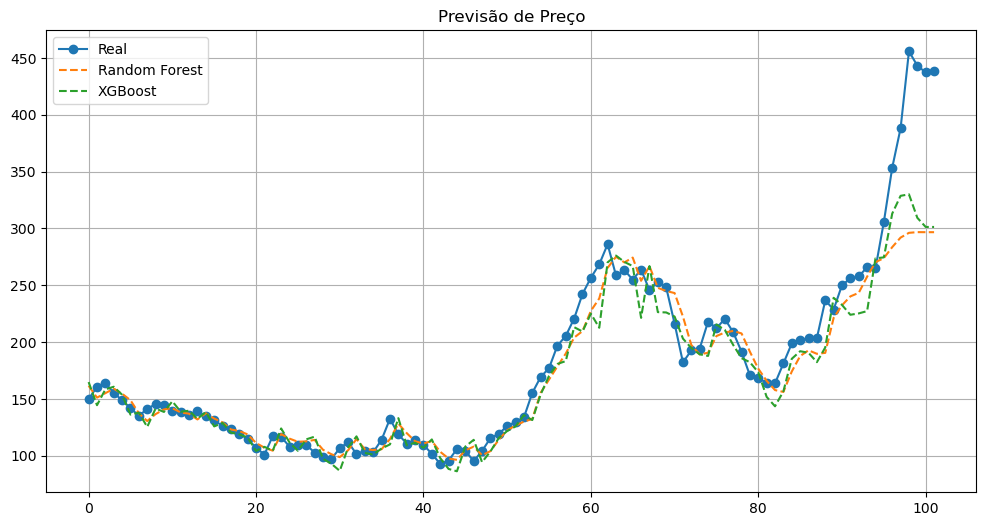

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Real', marker='o')
plt.plot(y_pred_rf, label='Random Forest', linestyle='--')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='--')
plt.title("Previsão de Preço")
plt.legend()
plt.grid(True)
plt.savefig('Random_XG.png')
plt.show()